## Let's extend our graph to work with either output!

### For this, we can use two ideas:

1. Add a node that will call our tool.

2. Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed.

In [ ]:
from langchain_ibm import ChatWatsonx, WatsonxLLM
from ibm_watson_machine_learning.metanames import GenTextParamsMetaNames as GenParams

credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "api key"
}

project_id = "project_id"
api_key = credentials.get("apikey")
project_url = credentials.get("url")

crdentials may vary , since i have access to granite model , im using it , depending on LLM u use credentials may vary , like open ai models need only open api key

In [22]:
llm = ChatWatsonx(
    model_id="ibm/granite-3-2-8b-instruct", 
    url=credentials.get("url"),
    apikey=credentials.get("apikey"),
    project_id=project_id,
    params={
        GenParams.DECODING_METHOD: "sample",
        GenParams.TEMPERATURE: 0.7
    },
)

In [23]:
def multiply(a:int , b:int):
    return a*b

In [31]:
llm_with_tools=llm.bind_tools([multiply])

In [32]:
from langchain_core.runnables import RunnableLambda
from langchain_core.messages import AIMessage
from langgraph.graph import MessagesState

def custom_tool_node(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        tool_name = tool_call["name"]
        args = tool_call["args"]
        
        if tool_name == "multiply":
            result = multiply(**args)
            return {"messages": [AIMessage(content=str(result))]}
    return state

In [33]:
from langgraph.graph import END
from langchain_core.messages import AIMessage

def custom_tools_condition(state: MessagesState) -> str:
    messages = state["messages"]
    last_message = messages[-1]
    
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"  # Route to the tools node if a tool call is detected
    return END  # Otherwise, end the workflow

### Dont think about 2 functions , even i took them from GPT because in earlier versions of langgraph , those wre present in langgraph.prebuilt library but now it seems its deprecated , so just understand the purpose of using these 2 funcitons

### We use built-in ToolNode and we can pass our tools as list so that a node now has list of tools
### We use built-in tools_condition as our conditional edge

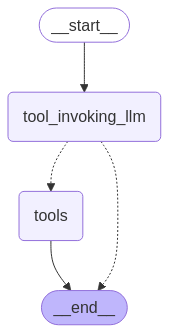

In [34]:
from IPython.display import Image
from langgraph.graph import StateGraph,START,END
from langgraph.graph import MessagesState


def tool_calling_llm(state:MessagesState):
    return {"messages" : [llm_with_tools.invoke(state["messages"])]}

builder=StateGraph(MessagesState)

builder.add_node("tool_invoking_llm",tool_calling_llm)
builder.add_node("tools",custom_tool_node)

builder.add_edge(START,"tool_invoking_llm")
builder.add_conditional_edges(
    "tool_invoking_llm",
    #if latest message from assistant is a tool call , tools_condition routes to tools else END
    custom_tools_condition,
)
builder.add_edge("tools",END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))



In [35]:
import pprint
from langchain_core.messages import AIMessage, HumanMessage
message=graph.invoke({"messages":HumanMessage(content="multiply 5 and 3")})
message

{'messages': [HumanMessage(content='multiply 5 and 3', additional_kwargs={}, response_metadata={}, id='273242b2-3a75-4564-9065-cff969078ce2'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'chatcmpl-tool-01bdace9a7864520baff364c2679905d', 'type': 'function', 'function': {'name': 'multiply', 'arguments': '{"a": 5, "b": 3}'}}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 227, 'total_tokens': 254}, 'model_name': 'ibm/granite-3-2-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-84854649dd271b6b75781d63a20193d3', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 3}, 'id': 'chatcmpl-tool-01bdace9a7864520baff364c2679905d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 227, 'output_tokens': 27, 'total_tokens': 254}),
  AIMessage(content='15', additional_kwargs={}, response_metadata={}, id='4d035e36-9a7b-43ee-bdc5-406d16434525')]}

In [36]:
message=graph.invoke({"messages":HumanMessage(content="what is answer when 22 divided by 3")})
message

{'messages': [HumanMessage(content='what is answer when 22 divided by 3', additional_kwargs={}, response_metadata={}, id='d3d99e92-b00a-4e10-b127-e9684ba4a38b'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 6, 'prompt_tokens': 232, 'total_tokens': 238}, 'model_name': 'ibm/granite-3-2-8b-instruct', 'system_fingerprint': '', 'finish_reason': 'tool_calls'}, id='chatcmpl-babfc1e2706572172b676568157a6399', usage_metadata={'input_tokens': 232, 'output_tokens': 6, 'total_tokens': 238})]}

### Yayy!
### we are able to acheive that our LLM uses tool for questions where its needed to use tool , for general questions which can be answered by LLM knowledge , our LLM is not using tools
### we are going good , lets gooo!